In [ ]:
from google.colab import files
files.upload()   # upload kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d hamdallak/the-iqothnccd-lung-cancer-dataset


Dataset URL: https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset
License(s): CC0-1.0
the-iqothnccd-lung-cancer-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip the-iqothnccd-lung-cancer-dataset.zip -d iq_oth_nccd


Archive:  the-iqothnccd-lung-cancer-dataset.zip
replace iq_oth_nccd/The IQ-OTHNCCD lung cancer dataset/Bengin cases/Bengin case (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
import os
for root, dirs, files in os.walk("iq_oth_nccd"):
    print(root, len(files))


iq_oth_nccd 0
iq_oth_nccd/The IQ-OTHNCCD lung cancer dataset 0
iq_oth_nccd/The IQ-OTHNCCD lung cancer dataset/Malignant cases 561
iq_oth_nccd/The IQ-OTHNCCD lung cancer dataset/Bengin cases 120
iq_oth_nccd/The IQ-OTHNCCD lung cancer dataset/Normal cases 416


In [15]:
!rm -rf "iq_oth_nccd/The IQ-OTHNCCD lung cancer dataset/.ipynb_checkpoints"


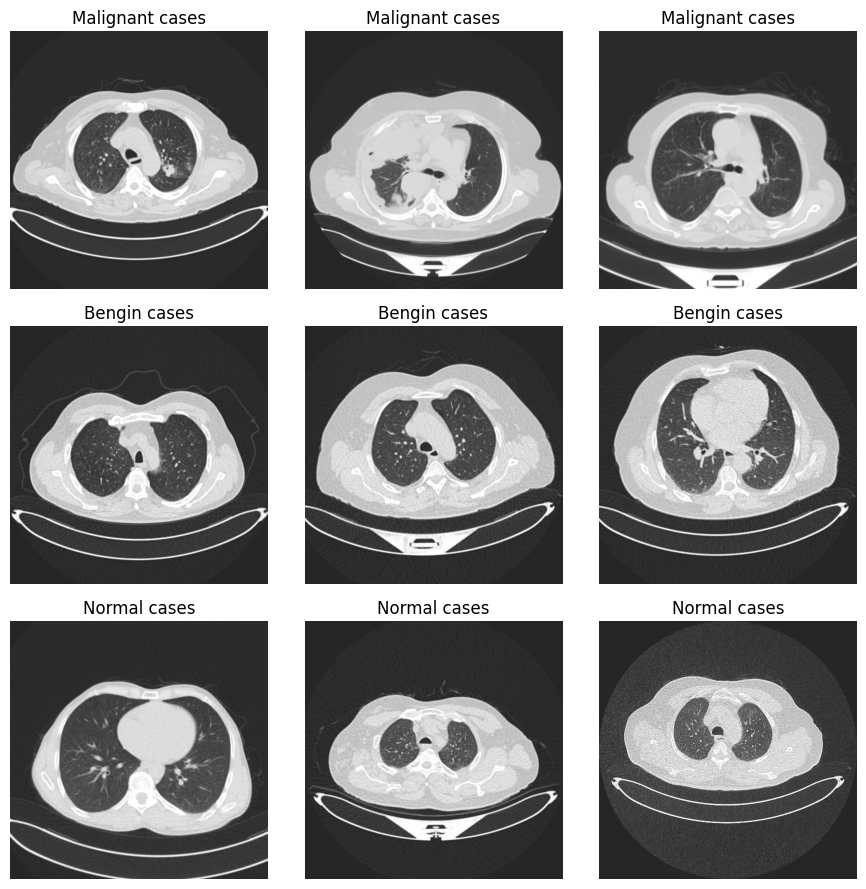

In [16]:
import os
from PIL import Image
import matplotlib.pyplot as plt

base = "iq_oth_nccd/The IQ-OTHNCCD lung cancer dataset"

classes = [
    c for c in os.listdir(base)
    if os.path.isdir(os.path.join(base, c)) and len(os.listdir(os.path.join(base, c))) > 0
]

plt.figure(figsize=(9,9))
idx = 1

for c in classes:
    imgs = os.listdir(os.path.join(base, c))[:3]   # 3 images per class
    for img_name in imgs:
        img_path = os.path.join(base, c, img_name)
        img = Image.open(img_path)

        plt.subplot(3, 3, idx)
        plt.imshow(img, cmap="gray")
        plt.title(c)
        plt.axis("off")
        idx += 1

plt.tight_layout()
plt.show()


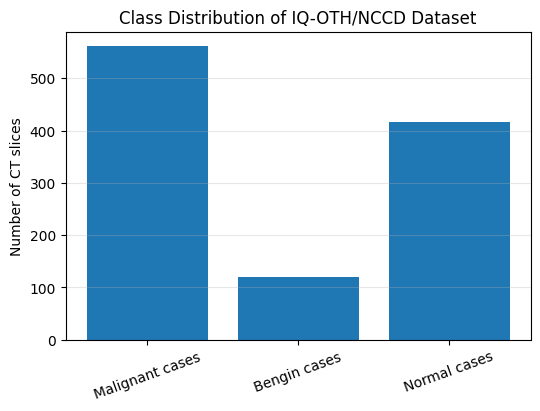

In [17]:
import matplotlib.pyplot as plt

class_counts = {
    c: len(os.listdir(os.path.join(base, c)))
    for c in classes
}

plt.figure(figsize=(6,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution of IQ-OTH/NCCD Dataset")
plt.ylabel("Number of CT slices")
plt.xticks(rotation=20)
plt.grid(axis="y", alpha=0.3)
plt.show()


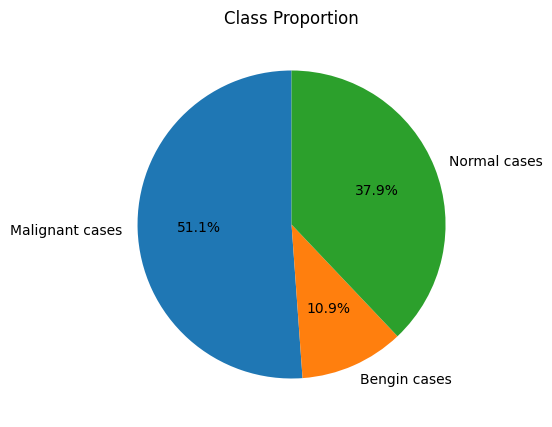

In [18]:
plt.figure(figsize=(5,5))
plt.pie(class_counts.values(),
        labels=class_counts.keys(),
        autopct="%1.1f%%",
        startangle=90)
plt.title("Class Proportion")
plt.show()


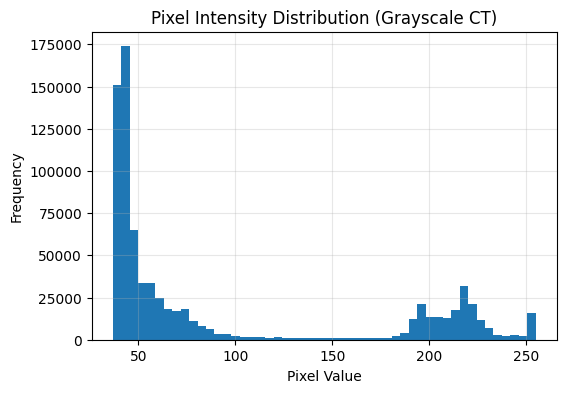

In [19]:
import numpy as np

pixels = []

for c in classes:
    img_path = os.path.join(base, c, os.listdir(os.path.join(base, c))[0])
    img = Image.open(img_path).convert("L")
    pixels.extend(np.array(img).flatten())

plt.figure(figsize=(6,4))
plt.hist(pixels, bins=50)
plt.title("Pixel Intensity Distribution (Grayscale CT)")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


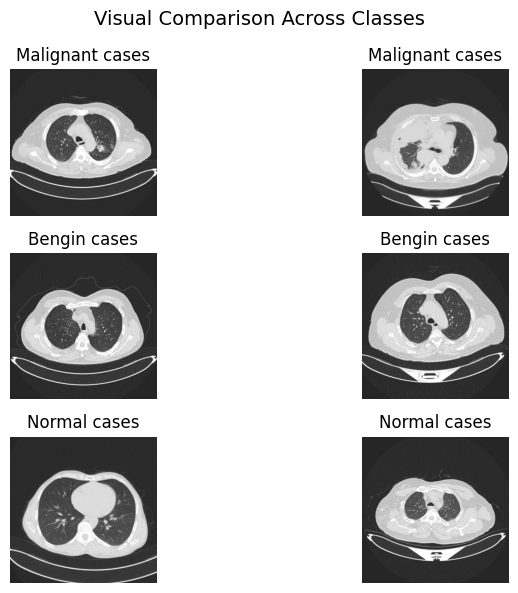

In [20]:
plt.figure(figsize=(9,6))
idx = 1

for c in classes:
    for img_name in os.listdir(os.path.join(base, c))[:2]:
        img = Image.open(os.path.join(base, c, img_name))
        plt.subplot(3, 2, idx)
        plt.imshow(img, cmap="gray")
        plt.title(c)
        plt.axis("off")
        idx += 1

plt.suptitle("Visual Comparison Across Classes", fontsize=14)
plt.tight_layout()
plt.show()


In [21]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


In [22]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = datasets.ImageFolder(base, transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
train_acc, val_acc = [], []
train_loss, val_loss = [], []

for epoch in range(40):
    # ---- TRAIN ----
    model.train()
    correct, total, running_loss = 0, 0, 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = out.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    train_acc.append(correct/total)
    train_loss.append(running_loss/len(train_loader))

    # ---- VALIDATION ----
    model.eval()
    correct, total, running_loss = 0, 0, 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            running_loss += loss.item()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    val_acc.append(correct/total)
    val_loss.append(running_loss/len(val_loader))

    print(f"Epoch {epoch+1} done")


Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done
Epoch 11 done
Epoch 12 done
Epoch 13 done
Epoch 14 done
Epoch 15 done
Epoch 16 done
Epoch 17 done
Epoch 18 done
Epoch 19 done
Epoch 20 done
Epoch 21 done
Epoch 22 done
Epoch 23 done
Epoch 24 done
Epoch 25 done
Epoch 26 done
Epoch 27 done
Epoch 28 done
Epoch 29 done
Epoch 30 done
Epoch 31 done
Epoch 32 done
Epoch 33 done
Epoch 34 done
Epoch 35 done
Epoch 36 done
Epoch 37 done
Epoch 38 done
Epoch 39 done
Epoch 40 done


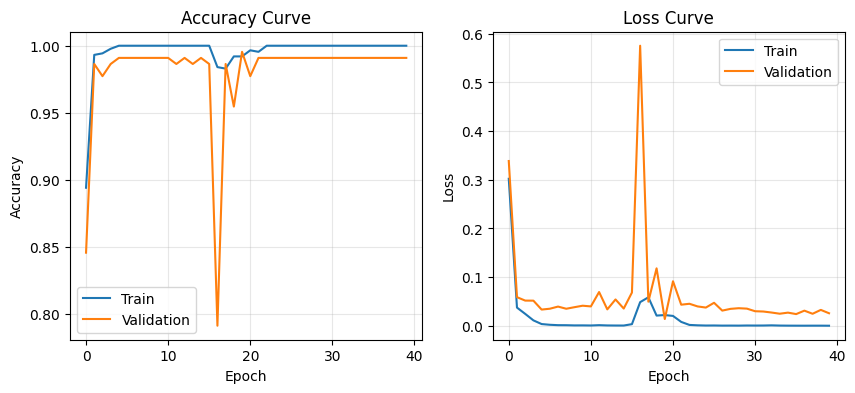

In [25]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_acc, label="Train")
plt.plot(val_acc, label="Validation")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(alpha=0.3)

plt.show()


In [26]:
torch.save(model.state_dict(), "lung_cancer_model_40.pth")


In [27]:
from torchvision.transforms.functional import to_tensor

class_names = dataset.classes

def predict_image(img_path):
    img = Image.open(img_path).convert("L")
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        out = model(img)
        prob = torch.softmax(out, dim=1)
        conf, pred = torch.max(prob, 1)

    return class_names[pred.item()], conf.item()


In [28]:
label, confidence = predict_image("/content/iq_oth_nccd/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (1).jpg")
print(label, confidence)


Malignant cases 0.9999589920043945


In [31]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

def gradcam_visual(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224,224))
    input_tensor = transform(Image.fromarray(img_resized)).unsqueeze(0).to(device)

    grayscale_cam = cam(input_tensor=input_tensor)[0]
    cam_img = show_cam_on_image(img_resized/255.0, grayscale_cam, use_rgb=True)

    plt.imshow(cam_img)
    plt.axis("off")
    plt.show()


In [23]:
import sys
!{sys.executable} -m pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=ffde17ef89e1a4188f6a601969707231c895c1d432df1eaceb32a979ea3d24ca
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


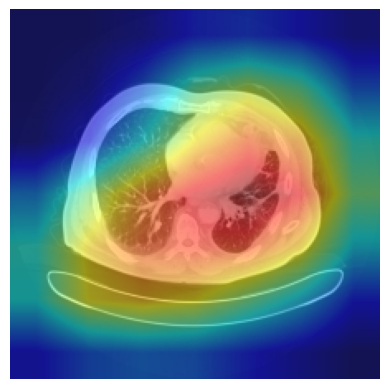

In [32]:
gradcam_visual("/content/iq_oth_nccd/The IQ-OTHNCCD lung cancer dataset/Malignant cases/Malignant case (1).jpg")
